# Intro
- Goal
- Hypothesis
- Data cycle
- Methods we'll use
- Significance

In the U.S. today, six in ten Americans live with at least one [chronic disease](https://www.cdc.gov/chronicdisease/index.htm) and this number only increases with age: over 2/3 of Medicare beneficiaries over 65 have 2 or more chronic diseases, with more than 15% having 6 or [more.](https://www.cdc.gov/pcd/issues/2015/14_0442.htm)

About 61 million people in the U.S., or a fifth of the U.S. population are enrolled in medicare today.

![medicare enrollment](./medicare.jpg)

Additionally, the U.S. has one of the highest costs of healthcare in the world:

![healthcare costs](./healthcare.jpg)

Individual hospitals pay hundreds of millions on medical and surgical supplies annually. By analyzing data on chronic disease rates and care costs in different regions of the U.S., hospitals can budget their supply costs more effectively to target common conditions, and the government can predict how much medicare and medicaid cost is going to treat these conditions.

Problems like these are well suited to data science, because we can apply computation techniques to gain insight on the prevalence and cost of chronic disease in the U.S. This tutorial will walk through the entire data science pipeline using Chronic Condition data from the U.S. Department of Health and Human Services. We will be collecting and processing data, performing exploratory analysis and visualization through plots and grouping to find trends in chronic diseases in different regions of the U.S., then using machine learning to create a model to interpret and give further insight on how hospitals can predict what chronic diseases will be prevalent in their area.

![datascience lifecycle chart from CMSC320 slides](./datacycle.png)

To work with our data, we'll be using Python. There's a few important Python libraries that we'll use for the different steps. 

Pandas is a library used to manipulate and analyze large amounts of data. Specifically, we're going to use it to store and clean up our data to make it easy to read and to help with the later steps.

Matplotlib is a plotting library which we'll use to show some relationships between demographics in our data. Pyplot is a collection of functions inside Matplotplib that helps us make figures like bar graphs and scatterplots and makes it easy to edit the display of them.

Scikit-learn is a a machine learning library for Python which we'll use to split our data, make a decision tree model for our data, and test how accurate our model is.

Finally, we import the warnings library to suppress warnings in our code.

In [20]:
# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')


First, we collect our data. We got our data from [data.gov.](https://data.gov/) It describes specfic chronic conditions based on demographics like age, medicare status, sex, and geographic region. We got this data in the form of a comma-separated values file, which makes it easy to store in a table like a pandas dataframe.

In [21]:
# Import CSV to pandas dataframe
df = pd.read_csv("data.csv")
df.head()

# Add prose about how we retreived the data and its source

,Bene_Geo_Lvl,Bene_Geo_Desc,Bene_Geo_Cd,Bene_Age_Lvl,Bene_Demo_Lvl,Bene_Demo_Desc,Bene_Cond,Prvlnc,Tot_Mdcr_Stdzd_Pymt_PC,Tot_Mdcr_Pymt_PC,Hosp_Readmsn_Rate,ER_Visits_Per_1000_Benes
0,State,Alabama,1.0,All,All,All,Alcohol Abuse,0.0188,25102.3405,23348.6039,0.2413,2184.7557
1,State,Alabama,1.0,65+,Dual Status,Medicare Only,Alcohol Abuse,0.0118,NaN,NaN,NaN,NaN
2,State,Alabama,1.0,<65,Dual Status,Medicare Only,Alcohol Abuse,0.0320,NaN,NaN,NaN,NaN
3,State,Alabama,1.0,All,Dual Status,Medicare Only,Alcohol Abuse,0.0147,NaN,NaN,NaN,NaN
4,State,Alabama,1.0,65+,Dual Status,Medicare and Medicaid,Alcohol Abuse,0.0238,NaN,NaN,NaN,NaN


We have a lot of columns in our data, and the column names aren't especially helpful to the average person to understand. We found a helpful dictionary for the headers [here](https://data.cms.gov/sites/default/files/2020-12/Specific%20Chronic%20Conditions%20Data%20Dictionary.pdf) so we'll rename these columns to make them more readable.

From here, we delete unneccesary data in our dataframe. This could be columns we don't need, like the beneficiary geographic code, rows with too much missing data to be useful for us, and entries that are too specific. We only want the state-wide data, not the county-specific and national information.

In [22]:
# Cleaning the data

# Deleting unneeded columns
df.drop(columns = 'Bene_Geo_Cd', inplace = True)

# Renaming columns
df = df.set_axis(['Geo_Lvl', 'State', 'Age_Lvl', 'Demographic', 'Demographic_Desc', 
                     'Condition', 'Prevalence', 'Medicare_Payment_Standardized', 
                     'Medicare_Payment', 'Hospital_Readmission_Rate', 'ER_Rate_Per_1000'], 
                     axis = 1)

# Deleting rows at end with too much missing data
df.drop(df.tail(21).index, inplace = True)

# Delete county-specific and national enteries
df = df.loc[df['Geo_Lvl'] == 'State']

df

,Geo_Lvl,State,Age_Lvl,Demographic,Demographic_Desc,Condition,Prevalence,Medicare_Payment_Standardized,Medicare_Payment,Hospital_Readmission_Rate,ER_Rate_Per_1000
0,State,Alabama,All,All,All,Alcohol Abuse,0.0188,25102.340500,23348.603900,0.2413,2184.7557
1,State,Alabama,65+,Dual Status,Medicare Only,Alcohol Abuse,0.0118,NaN,NaN,NaN,NaN
2,State,Alabama,<65,Dual Status,Medicare Only,Alcohol Abuse,0.0320,NaN,NaN,NaN,NaN
3,State,Alabama,All,Dual Status,Medicare Only,Alcohol Abuse,0.0147,NaN,NaN,NaN,NaN
4,State,Alabama,65+,Dual Status,Medicare and Medicaid,Alcohol Abuse,0.0238,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
236098,State,Wyoming,65+,All,All,Hypertension,0.4185,14091.718674,16051.028884,NaN,NaN
236099,State,Wyoming,65+,All,All,Ischemic Heart Disease,0.2113,16965.132331,19512.892238,NaN,NaN
236100,State,Wyoming,65+,All,All,Osteoporosis,0.0512,18563.682367,21084.682682,NaN,NaN
236101,State,Wyoming,65+,All,All,Schizophrenia and Other Psychotic Disorders,0.0067,21828.833222,24658.202736,NaN,NaN


Now that our data has been collected and cleaned, we need to get a sense of what trends are visible in our data. We eventually want to make a decision tree for this data, so it's important to understand what factors we can use to predict conditions. We'll be doing some exploratory data analysis by visualizing our data through plots.

First, we want to get a sense of how much each state spends on chronic conditions. Our code keeps only the relevant columns, then groups them by state and sums up the Medicare_Payment per state.

In [23]:
# Bar graph of state vs per capita spending

df1 = df[["State", "Medicare_Payment"]]

df1 = df1.dropna(subset=['Medicare_Payment'])

df1 = df1.groupby(['State']).sum()

df1.head()


,Medicare_Payment
State,
Alabama,1.264863e+06
Alaska,1.650902e+06
Arizona,1.474884e+06
Arkansas,1.268369e+06
California,1.912136e+06


<Axes: xlabel='State'>

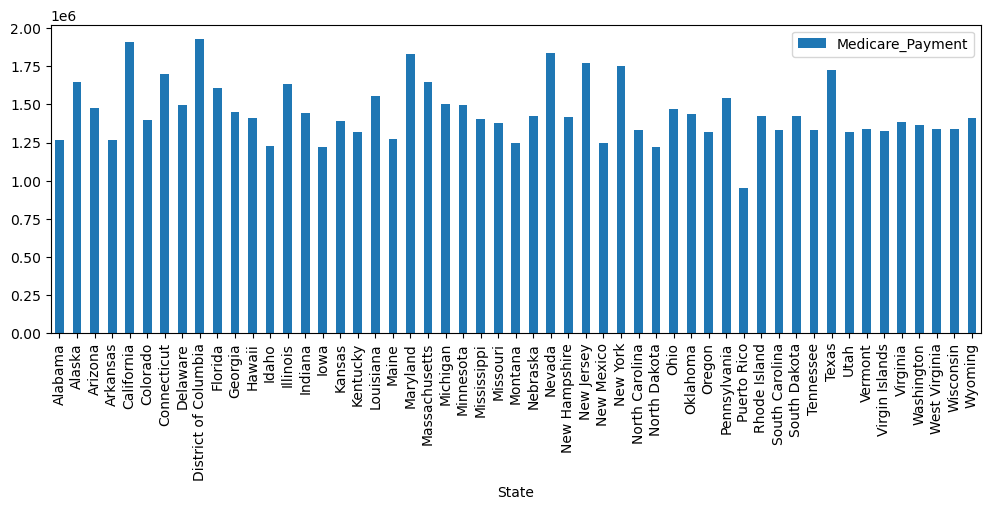

In [24]:
df1.plot.bar(figsize=(12, 4))

This graph shows the total Medicare spending (ie. total payments for all services per capita) for each of the 21 different chronic conditions identified using Medicare claims. This tells us that just having 1 person with each chronic condition in a state costs 1 million dollars of Medicare. We can see some interesting trends--Puerto Rico spends a lost less of Medicare dollars than the states, and the largest spender of Medicare dollars on chronic conditions per capita is D.C.

For the next graph, we were curious how per capita spending depends on what condition a person has. Are there certain conditions that are more expensive than others? There's a large variety of conditions in our data with vastly different treatments, so it makes sense that they would all have varying costs. Additionally, this means that if we can predict what condition a person has based on different demographics, then we can also predict the cost of treatment on Medicare.

In [25]:
# Bar graph of disease vs per capita spending

df2 = df[["Condition", "Medicare_Payment"]]

df2 = df2.dropna(subset=['Medicare_Payment'])

df2 = df2.groupby(['Condition']).sum()

df2

,Medicare_Payment
Condition,
Alcohol Abuse,4.007717e+06
Alzheimer's Disease/Dementia,4.370870e+06
Arthritis,2.642109e+06
Asthma,3.492510e+06
Atrial Fibrillation,5.027974e+06
Autism Spectrum Disorders,1.718904e+06
COPD,4.274726e+06
Cancer,3.688560e+06
Chronic Kidney Disease,3.999802e+06


<Axes: xlabel='Condition'>

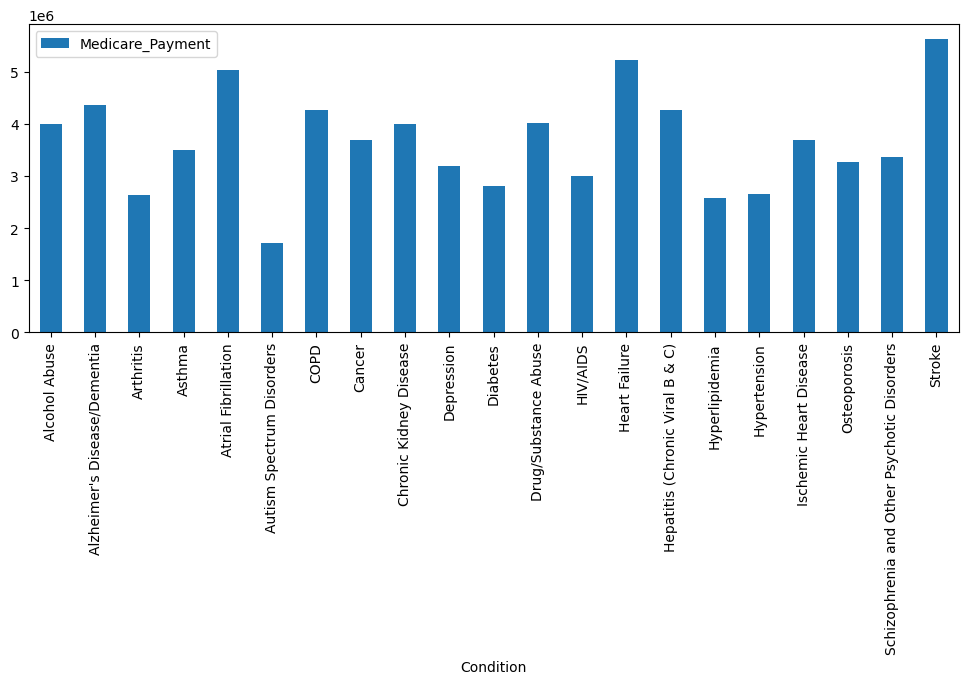

In [26]:
df2.plot.bar(figsize=(12, 4))

We can see that conditions like Artrial Fibrillation, Heart Failure, and Stroke have much higher Medicare payments compared to conditions like Autism Spectrum Disorder. This makes sense as the former conditions require lots of intensive treatments and surgeries while ASD requires treatments like therapy and other care services depending on the severity of the diagnosis. This means that predicting a condition does appear to have some connection with the Medicare cost of treating that condition.

Now, let's see if there appears to be a connection between the state someone lives in and the prevalence of chronic conditions. Our thought process behind this is that there could be states with higher populations of elderly people, or with environmental factors like pollution or lower average socio-economic status which then influences the rate at which people get chronic conditions.

In [27]:
# Bar graph of state vs condition

df3 = df[["State", "Prevalence", "Medicare_Payment"]]

df3 = df3.dropna(subset=['Medicare_Payment'])

df3.drop(columns = 'Medicare_Payment', inplace = True)

df3 = df3.groupby(['State']).sum()

df3.head()

,Prevalence
State,
Alabama,9.8964
Alaska,6.5883
Arizona,8.2265
Arkansas,8.9524
California,8.6566


<Axes: xlabel='State'>

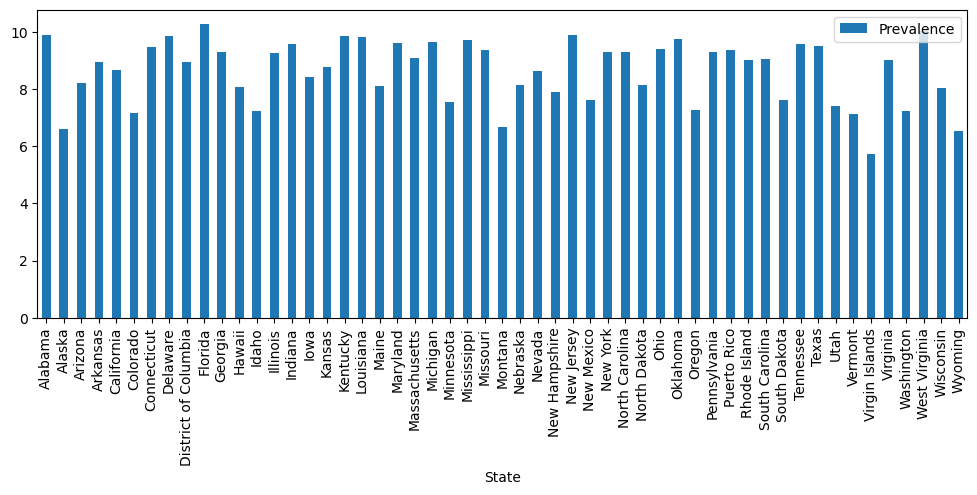

In [28]:
df3.plot.bar(figsize=(12, 4))

We can see that states like Alabama, Florida, and West Virginia have the highest prevalence for chronic conditions, while Alaska, Montana, and the Virgin Islands have the least. Prevelance was measured by taking the beneficiaries with a particular condition and dividing them by the total number of beneficiaries in the population (people with Medicare/Medicaid in the state.) It's interesting to see that in states with lower population densities (Alaska and Montana,) we see a lower prevalence for chronic conditions. Other reasons for this trend could be that fewer people in these states are on Medicare, or that they don't go to the hospital when they might need to. Either way, we see that there does appear to be a connection between the state someone lives in and the prevalance of chronic conditions.

We next want to see if there's a trend between age and prevalence for each state because we see that there's a split between people over 65 and under 65 in our data.

In [29]:
# Plotting age vs prevalence for each state

df4 = df[["State", "Age_Lvl", "Prevalence", "Medicare_Payment"]]

df4 = df4.dropna(subset=['Medicare_Payment'])

df4.drop(columns = 'Medicare_Payment', inplace = True)

df4 = df4.drop(df4[df4['Age_Lvl'] == 'All'].index)

df4 = df4.groupby(['State', 'Age_Lvl']).sum()

df4 = df4.reset_index()

df4

,State,Age_Lvl,Prevalence
0,Alabama,65+,3.6085
1,Alabama,<65,2.8433
2,Alaska,65+,2.1822
3,Alaska,<65,2.2187
4,Arizona,65+,2.9118
...,...,...,...
101,West Virginia,<65,3.0279
102,Wisconsin,65+,2.8377
103,Wisconsin,<65,2.4171
104,Wyoming,65+,2.2115


This plot took a bit more formatting to show the key and titles for each axis, and to modify where the ticks in the graph are shown for ages.

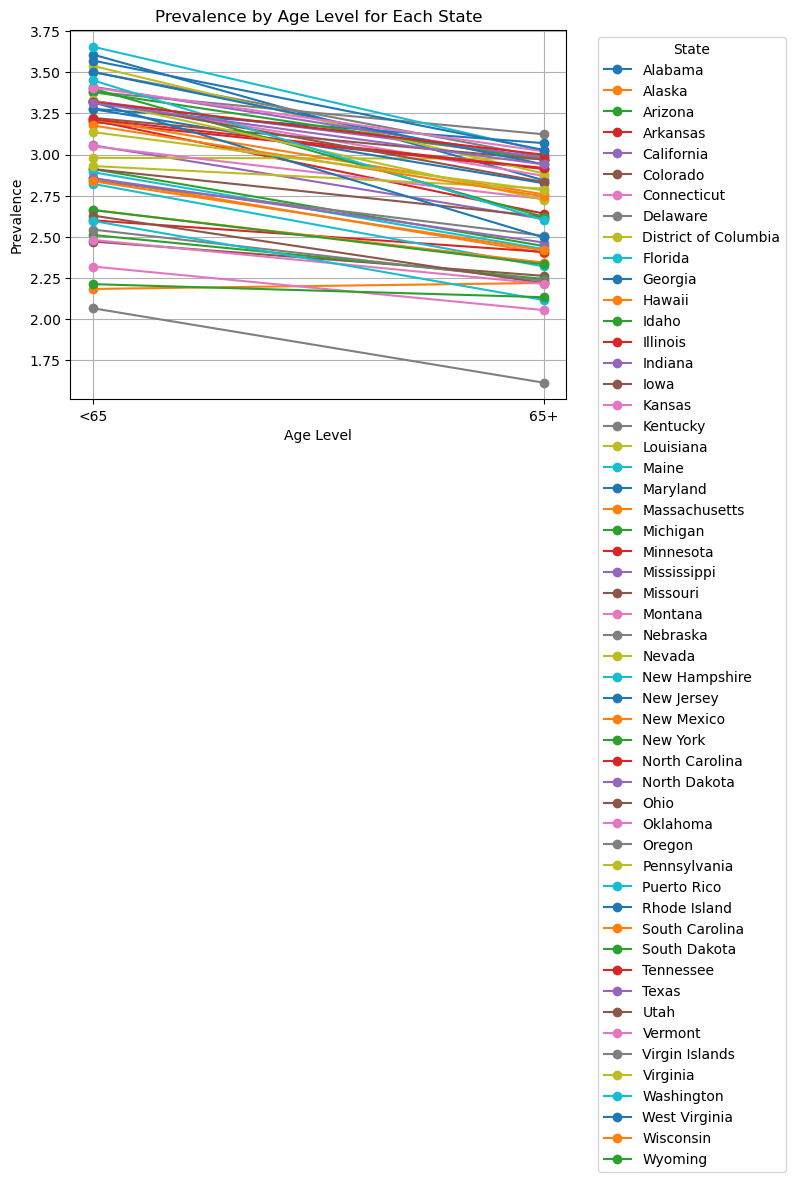

In [30]:
# Set the index to ['State', 'Age_Lvl']
df4.set_index(['State', 'Age_Lvl'], inplace=True)

# Unstack the 'State' index level to pivot the data
df_unstacked = df4['Prevalence'].unstack(level=0)

# Plotting
df_unstacked.plot(kind='line', marker='o')

# Add labels and title
plt.xlabel('Age Level')
plt.ylabel('Prevalence')
plt.title('Prevalence by Age Level for Each State')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(ticks=[0, 1], labels=['<65', '65+'])

# Show plot
plt.show()

We see that there's less prevalence of chronic conditions for the elderly compared to younger population. This is interesting because we'd expect general health to decrease as people age, especially because chances of conditions like organ failure and stroke increase with age. However, this could be caused by several confounding variables. Maybe younger populations have better access to healthcare, or younger populations on Medicaid are more at risk for health conditions due to lower socioeconomic status while all people over 65 are eligible for medicare, including those who have the means to get medical assistance before conditions become more severe.

Finally, we wanted to learn more about costs for each condition. We graph the prevalence of chronic conditions vs. the cost. This is interesting because more prevalent conditions are probably more researched to try and bring treatment costs down, but there are also very prevalent conditions that are expensive to treat due to the nature of the condition--like organ failure requiring several surgeries and further treatments for complications.

In [31]:
# Plotting prevalence vs cost for each state

df5 = df[["State", "Prevalence", "Medicare_Payment"]]

df5 = df5.dropna(subset=['Medicare_Payment'])

df5 = df5.groupby(['State']).sum()

df5 = df5.reset_index()

df5.drop(columns = 'State', inplace = True)

df5 = df5.set_index('Prevalence').sort_index()

df5.head()

,Medicare_Payment
Prevalence,
5.7304,1.324818e+06
6.5453,1.412222e+06
6.5883,1.650902e+06
6.6581,1.249322e+06
7.1312,1.338816e+06


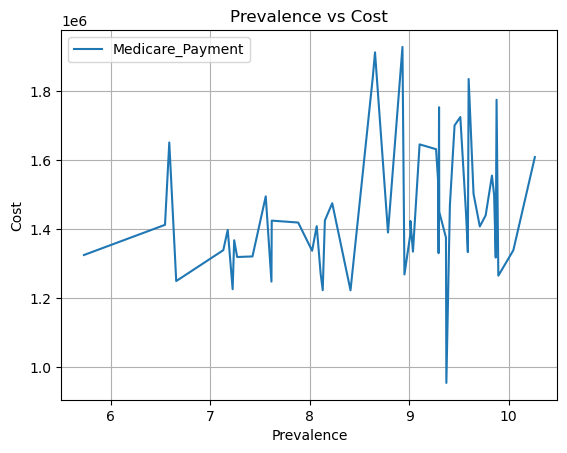

In [32]:
# Plotting
df5.plot()

# Add labels and title
plt.xlabel('Prevalence')
plt.ylabel('Cost')
plt.title('Prevalence vs Cost')
plt.grid(True)

# Show plot
plt.show()

We found that there didn't appear to be much of a trend between prevelance and cost of conditions. It appears that there's conditions which are prevalant and relatively cheap to treat, and vice versa.

## Decision Tree

Now we move onto the next step in the data science pipeline. We've seen some trends in our data, and now we want to create a model using machine learning to help use some of the variables in our data to predict what condition someone is likely to have.

A decision tree is like a flow chart. We have a class we want to predict--in this case it's the condition someone may have--and a decision tree asks a series of yes-no questions to determine what the value of that class is based on the values of our chosen feature. We're choosing to use this model because our data is categorical and a decision tree makes it easier to visualize and explain our complex data and classify conditions.

As previously shown, our data is quite large--we have entries for each of the 21 conditions in every state (plus Puerto Rico and the Virgin Islands) and these entries are split further based on sex, race, and Medicare status. This means it's quite difficult for a human to decide what values to split on. If we had smaller data--something like determining whether someone has a stroke or a heart condition, we could use a small set of variables and decide what condition someone has relatively easily. But in our case, with lots of different possible conditions, 52 regions, and complicated prevalence information, how do we know what values are significant enough to split our tree into thinking a case is one condition vs. another? 

Therefore, this is a good situation to use a machine learning model. Scikit-learn's decision tree model will split our data into a tree for us and create a model which we can test the accuracy of. 

First, we need to format our data properly to use Scikit-learn's functions. We decided to use these as our prediction features to predict what chronic condition someone is likely to have: state, age, sex, and prevalence. The model doesn't accept values like "Male," "<65" and "California," so we need to rework our categorical values into numerical data instead. For age and sex, this is simple. We encode <65 to be 0, and 65+ to be 1, and same for female and male values.  

In [33]:
# Formatting data

dfDT = df

dfDT.drop(columns = ['Medicare_Payment_Standardized', 'Medicare_Payment', 'Hospital_Readmission_Rate', 'ER_Rate_Per_1000'], inplace = True)

dfDT = dfDT[~dfDT.isin(['All']).any(axis=1)]

dfDT['Age_Lvl'] = dfDT['Age_Lvl'].replace({'<65': 0, '65+': 1})

# Deleting all except sex
dfDT = dfDT[dfDT.isin(['Sex']).any(axis=1)]

dfDT.drop(columns = ['Demographic'], inplace = True)

dfDT.rename(columns={'Demographic_Desc' : 'Sex'}, inplace=True)

dfDT['Sex'] = dfDT['Sex'].replace({'Female': 0, 'Male': 1})

dfDT.head()

,Geo_Lvl,State,Age_Lvl,Sex,Condition,Prevalence
7,State,Alabama,1,0,Alcohol Abuse,0.0058
8,State,Alabama,0,0,Alcohol Abuse,0.0235
10,State,Alabama,1,1,Alcohol Abuse,0.0232
11,State,Alabama,0,1,Alcohol Abuse,0.0537
20,State,Alabama,1,0,Alzheimer's Disease/Dementia,0.1547
...,...,...,...,...,...,...
15000,State,Wyoming,0,1,Schizophrenia and Other Psychotic Disorders,0.0873
15009,State,Wyoming,1,0,Stroke,0.0225
15010,State,Wyoming,0,0,Stroke,0.0176
15012,State,Wyoming,1,1,Stroke,0.0211


For the states, however, we'll need to use One-Hot-Encoding because we're dealing with 52 different categories, not just 2. Instead of having a state like "California" be a value inside the column "State," we'll have each state be its own column. Then, for the entries that take place in California, the value for the column "California" will be 1, while the values for each other state are 0. In this way, we split the one column of states into 52 different columns which are mostly 0s, and only 1 for the entries in that state. This will take a lot more space to store, but because we saw a trend between the state someone lives in and the condition someone has in our graphs above, it seems like a worthwhile trade-off to make a more accurate model.

Sklearn's library comes with its own function for One-Hot-Encoding, which makes this process easier.

In [34]:
dfDT.drop(columns = 'Geo_Lvl', inplace = True)

categorical_columns = dfDT[['State']].columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(dfDT[['State']])
#one_hot_encoded
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
df_encoded = pd.concat([dfDT, one_hot_df], axis=1)
df_encoded = df_encoded.drop(categorical_columns, axis=1)

#one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out)
df_encoded = df_encoded.dropna()
df_encoded.head()

,Age_Lvl,Sex,Condition,Prevalence,State_Alabama,State_Alaska,State_Arizona,State_Arkansas,State_California,State_Colorado,...,State_Texas,State_Unknown,State_Utah,State_Vermont,State_Virgin Islands,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming
7,1.0,0.0,Alcohol Abuse,0.0058,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,Alcohol Abuse,0.0235,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1.0,1.0,Alcohol Abuse,0.0232,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,1.0,Alcohol Abuse,0.0537,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,1.0,0.0,Alzheimer's Disease/Dementia,0.1547,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4522,0.0,1.0,Drug/Substance Abuse,0.1021,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4531,1.0,0.0,HIV/AIDS,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4532,0.0,0.0,HIV/AIDS,0.0027,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4534,1.0,1.0,HIV/AIDS,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


The data we're going to use as predictor values for our tree is in the right format now. We need a list of conditions that our tree needs to classify our data into. We do a similar process as what we did for the states, but for the class values, we use cardinal numbers instead of one-hot-encoding. This just means our tree will output a number like '8' instead of a string like "Depression."

In [35]:
# encode conditions
df_encoded["Condition"] = df_encoded["Condition"].replace({'Alcohol Abuse': 0, "Alzheimer's Disease/Dementia": 1, 'Arthritis': 2, 'Asthma': 3,
 'Atrial Fibrillation': 4,  'Autism Spectrum Disorders': 4,  'COPD': 5, 'Cancer': 6, 
 'Chronic Kidney Disease': 7, 'Depression': 8, 'Diabetes': 9,  'Drug/Substance Abuse': 10, 
 'HIV/AIDS': 11,  'Heart Failure': 12,  'Hepatitis (Chronic Viral B & C)': 13, 
 'Hyperlipidemia': 14,  'Hypertension': 15, 'Ischemic Heart Disease': 16, 'Osteoporosis': 17,
 'Schizophrenia and Other Psychotic Disorders': 18, 'Stroke': 19})
df_encoded.head()

,Age_Lvl,Sex,Condition,Prevalence,State_Alabama,State_Alaska,State_Arizona,State_Arkansas,State_California,State_Colorado,...,State_Texas,State_Unknown,State_Utah,State_Vermont,State_Virgin Islands,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming
7,1.0,0.0,0,0.0058,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0,0.0235,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1.0,1.0,0,0.0232,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,1.0,0,0.0537,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,1.0,0.0,1,0.1547,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4522,0.0,1.0,10,0.1021,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4531,1.0,0.0,11,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4532,0.0,0.0,11,0.0027,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4534,1.0,1.0,11,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Now our data is all in the right format to create our decision tree!
All that's left is to split our data into a training set and a testing set. We use scikit-learn's function to split our data randomly so that 70% of it is used to train our tree, and then 30% is used to test how accurate our tree is.

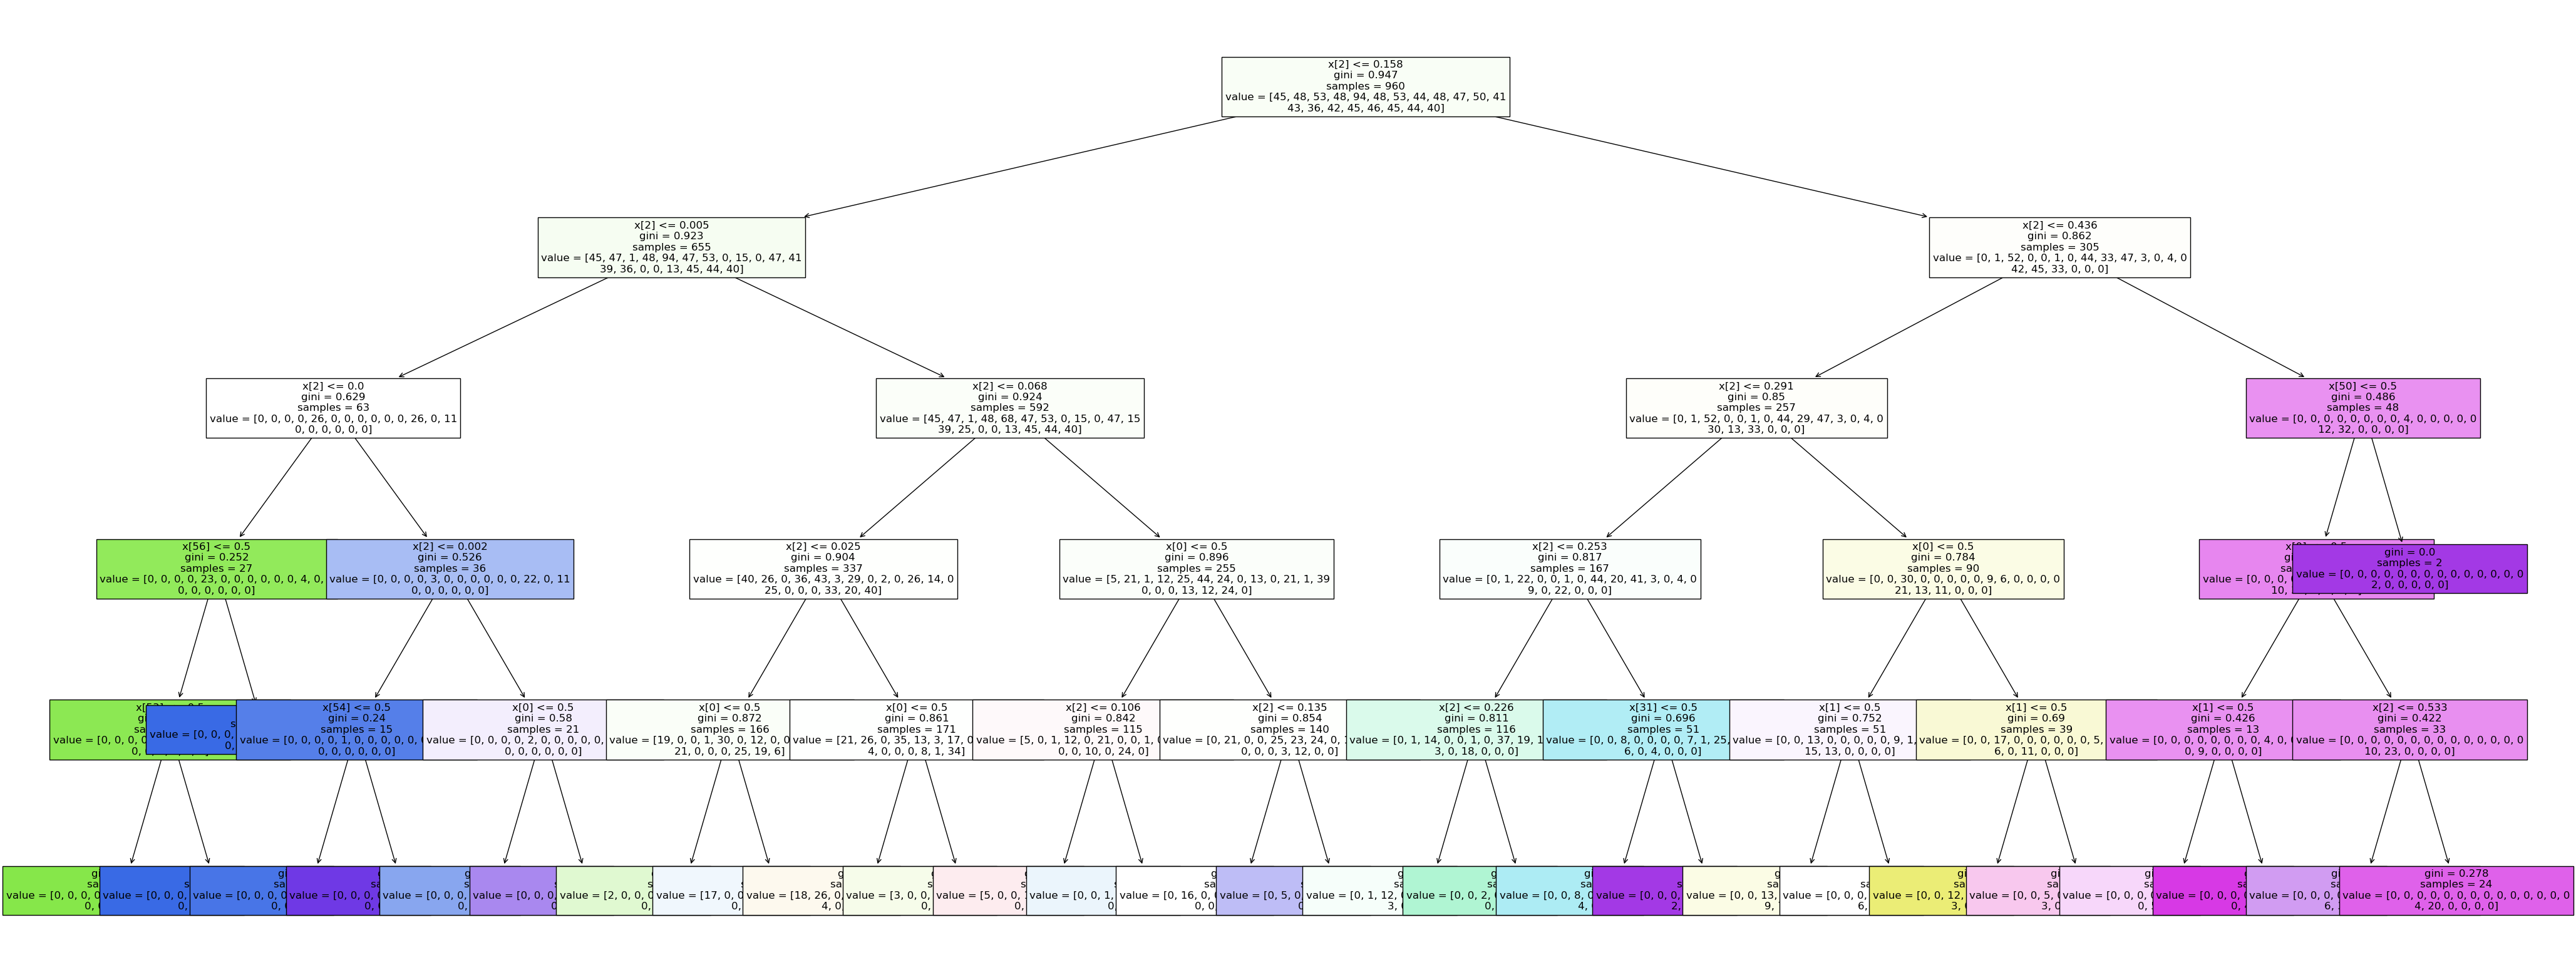

In [36]:
y = df_encoded["Condition"]
X = df_encoded.drop(columns ='Condition')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X_train, y_train)
plt.figure(figsize=(50,20))
tree.plot_tree(clf, fontsize=12, filled=True)
plt.show()

This is the output of our tree, but it's a bit hard to read for a person. We know that it splits on data until it comes up with a final condition classifier. We can use another scikit-learn function on our test data to get a metric for how accurate our model is. This is the accuracy_score function from the metrics library.

In [40]:
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.2815533980582524


We can see that with a tree of depth 5, our model is 28% percent accurate at determining what condition someone has based on the features we used from our data. We chose a depth of 5 as a good starting point. If we increase this value by too much, our tree will begin to overfit our dataset, making it less reliable overall.

Our tree is 6 times more accurate than picking a condition by chance, considering that there's a 1/21 = 4% chance of guessing a condition with no information. We were working with only the state someone is in, their sex, whether they are below/above 65 years of age, and the prevalence of the condition in their state, and not any actual symptoms, so it's very interesting to note how accurate our model is purely based on demographic and environmental information.

In [38]:
# Formatting data for race tree

dfDT2 = df.copy()

dfDT2.drop(columns = ['Medicare_Payment_Standardized', 'Medicare_Payment', 'Hospital_Readmission_Rate', 'ER_Rate_Per_1000'], inplace = True)

dfDT2 = dfDT2[~dfDT2.isin(['All']).any(axis=1)]

dfDT2['Age_Lvl'] = dfDT2['Age_Lvl'].replace({'<65': 0, '65+': 1})

# Deleting all except race
dfDT2 = dfDT2[dfDT2.isin(['Race']).any(axis=1)]

dfDT2.drop(columns = ['Demographic'], inplace = True)

dfDT2.rename(columns={'Demographic_Desc' : 'Race'}, inplace=True)

dfDT2.dropna()

race_dummies = pd.get_dummies(dfDT2['Race'], prefix='Race')

race_dummies = race_dummies.astype(int)

dfDT2 = pd.concat([dfDT2, race_dummies], axis=1)

dfDT2.drop('Race', axis=1, inplace=True)

dfDT2

KeyError: "['Medicare_Payment_Standardized', 'Medicare_Payment', 'Hospital_Readmission_Rate', 'ER_Rate_Per_1000'] not found in axis"